In [401]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from nltk import ngrams
import matplotlib.pyplot as plt

In [2]:
def readData(root,train = True):
    if train == True:
        directory = os.path.join(root,'train')
    else:
        directory = os.path.join(root,'test')
        
    reviews = []
    labels = []
    
    dir_pos = os.path.join(directory,'pos')
    for file in os.listdir(dir_pos):
        reviews.append(open(os.path.join(dir_pos, file)).read())
        labels.append(1)
    dir_neg = os.path.join(directory,'neg')
    for file in os.listdir(dir_neg):
        reviews.append(open(os.path.join(dir_neg, file)).read())
        labels.append(-1)
        
    return reviews,labels
        

In [215]:
root = '/Users/limanwen/Desktop/Data-Science/Fall2018/NLP/hw1/aclImdb'
reviews_train,labels_train = readData(root,train = True)
reviews_test,labels_test = readData(root,train = False)

In [251]:
X_train, X_val, y_train, y_val = train_test_split(reviews_train,lables_train, test_size=0.2, random_state=42)

In [163]:
spacy.lang.en.stop_words

<module 'spacy.lang.en.stop_words' from '/anaconda3/lib/python3.6/site-packages/spacy/lang/en/stop_words.py'>

In [507]:
import spacy
import string
from tqdm import tqdm_notebook
from spacy.lang.en import STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stop_words = STOP_WORDS

def remove_punc_and_html_tag(parsed):
    return [re.sub(r'<br|/>','',token.text.lower()).strip() for token in parsed if (token.text != 'br' and token.text not in punctuations and token.text.lower() not in stop_words)]

def remove_punctuation(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations and token.text.lower() not in stop_words)]

def remove_punc_and_stop_words(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations and token.text.lower() not in stop_words)]

def tokenize_dataset(dataset, max_n_gram, remove_punc = True, remove_stopwords = True, remove_html = True):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=5)):
        
        if remove_punc == True and remove_stopwords == True and remove_html == True:
            tokens = remove_punc_and_html_tag(sample)
        elif remove_punc == True and remove_stopwords == True and remove_html == False:
            tokens = remove_punc_and_stop_words(sample)
        elif remove_punc == True and remove_stopwords == False and remove_html == False:
            tokens = remove_punctuation(sample)
        else:
            tokens = [token.text.lower() for token in sample]
            
        token_new = tokens.copy()
        for i in range(2,max_n_gram+1):
            n_grams = ngrams(tokens,i)
            cur_tokens = [' '.join(ngram) for ngram in n_grams]
            token_new += cur_tokens
            
        token_dataset.append(token_new)
        all_tokens += tokens

    return token_dataset, all_tokens

In [526]:
token_train1, all_train1 = tokenize_dataset(X_train,3)

A Jupyter Widget

In [527]:
token_val1, all_val1 = tokenize_dataset(X_val,3)

A Jupyter Widget

In [530]:
from collections import Counter

max_vocab_size = 50000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train1)
token2id_val, id2token_val = build_vocab(all_val1)


In [264]:

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5832 ; token tapes
Token tapes; token id 5832


In [531]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(token_train1)
val_data_indices = token2index_dataset(token_val1)


# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [559]:
len(val_data_indices[2])

180

In [258]:
y_train = [0 if x==-1 else x for x in y_train]
y_val = [0 if x==-1 else x for x in y_val]
labels_test = [0 if x==-1 else x for x in labels_test]


In [532]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def IMDB_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
train_loader = IMDBDataset(train_data_indices, y_train)
val_loader = IMDBDataset(val_data_indices, y_val)
test_loader = IMDBDataset(test_data_indices, labels_test)

BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)
val_dataset = IMDBDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)





In [578]:
len(val_dataset)

5000

In [381]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)

    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
       
        out = torch.sum(out, dim=1)
        
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
     
        # return logits
        out = self.linear(out.float())
        
        return out



In [581]:
from torch.optim.lr_scheduler import StepLR, LambdaLR
learning_rate = 0.005
num_epochs = 4 # number epoch to train


emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#lambda1 = lambda epoch: epoch // 625
#lambda2 = lambda epoch: 0.5 ** epoch
#scheduler = LambdaLR(optimizer, lr_lambda=lambda2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.4)

# Function for testing the model
def test_model(loader, model,verbose = False):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    counter = 0
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        #print('softmax')
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        
        comp = predicted.eq(labels.view_as(predicted))
        
        correct += comp.sum().item()
        comp = comp.numpy()
        
        if verbose == True:
            for i in range(len(comp)):
                print (i,comp[i]==[1], 'predicted', predicted[i])
                
        counter += 1        
    return (100 * correct / total)

train_loss_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    #print(epoch)
    scheduler.step()
    val_temp_list = []
    counter = 0
    for i, (data, lengths, labels) in enumerate(train_loader):
        
        
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        
        optimizer.zero_grad()
        
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        
        optimizer.step()
        
        # validate every 100 iterations
        
        
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       #epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            val_temp_list.append(val_acc)
            
        if i == 624:
            print('epoch',epoch,'batch',i)
            val_acc = test_model(val_loader, model,verbose = True)
            
        counter += 1
        
        
        
    val_acc_list.append(np.max(val_temp_list))
    return val_acc_list




epoch 0 batch 624
0 [ True] predicted tensor([1])
1 [ True] predicted tensor([1])
2 [ True] predicted tensor([1])
3 [ True] predicted tensor([1])
4 [ True] predicted tensor([1])
5 [ True] predicted tensor([1])
6 [ True] predicted tensor([1])
7 [False] predicted tensor([1])
8 [ True] predicted tensor([0])
9 [False] predicted tensor([0])
10 [ True] predicted tensor([0])
11 [ True] predicted tensor([0])
12 [ True] predicted tensor([0])
13 [ True] predicted tensor([1])
14 [ True] predicted tensor([0])
15 [ True] predicted tensor([1])
16 [ True] predicted tensor([0])
17 [ True] predicted tensor([0])
18 [False] predicted tensor([0])
19 [False] predicted tensor([0])
20 [ True] predicted tensor([0])
21 [ True] predicted tensor([0])
22 [ True] predicted tensor([1])
23 [ True] predicted tensor([1])
24 [ True] predicted tensor([1])
25 [ True] predicted tensor([1])
26 [ True] predicted tensor([1])
27 [ True] predicted tensor([1])
28 [False] predicted tensor([1])
29 [ True] predicted tensor([1])
30

14 [ True] predicted tensor([0])
15 [ True] predicted tensor([0])
16 [ True] predicted tensor([1])
17 [ True] predicted tensor([1])
18 [ True] predicted tensor([0])
19 [False] predicted tensor([0])
20 [ True] predicted tensor([0])
21 [ True] predicted tensor([0])
22 [ True] predicted tensor([1])
23 [ True] predicted tensor([1])
24 [False] predicted tensor([0])
25 [False] predicted tensor([0])
26 [ True] predicted tensor([1])
27 [ True] predicted tensor([1])
28 [ True] predicted tensor([0])
29 [False] predicted tensor([1])
30 [False] predicted tensor([0])
31 [ True] predicted tensor([1])
0 [ True] predicted tensor([0])
1 [ True] predicted tensor([1])
2 [ True] predicted tensor([0])
3 [False] predicted tensor([1])
4 [ True] predicted tensor([0])
5 [ True] predicted tensor([1])
6 [ True] predicted tensor([1])
7 [ True] predicted tensor([0])
8 [ True] predicted tensor([1])
9 [False] predicted tensor([0])
10 [ True] predicted tensor([1])
11 [ True] predicted tensor([1])
12 [ True] predicted

11 [ True] predicted tensor([0])
12 [ True] predicted tensor([0])
13 [False] predicted tensor([1])
14 [ True] predicted tensor([0])
15 [ True] predicted tensor([0])
16 [ True] predicted tensor([0])
17 [False] predicted tensor([1])
18 [ True] predicted tensor([1])
19 [ True] predicted tensor([0])
20 [ True] predicted tensor([1])
21 [ True] predicted tensor([1])
22 [ True] predicted tensor([0])
23 [False] predicted tensor([0])
24 [ True] predicted tensor([0])
25 [ True] predicted tensor([1])
26 [ True] predicted tensor([1])
27 [ True] predicted tensor([0])
28 [False] predicted tensor([1])
29 [ True] predicted tensor([1])
30 [ True] predicted tensor([1])
31 [ True] predicted tensor([0])
0 [ True] predicted tensor([1])
1 [ True] predicted tensor([1])
2 [ True] predicted tensor([0])
3 [ True] predicted tensor([0])
4 [ True] predicted tensor([1])
5 [ True] predicted tensor([1])
6 [ True] predicted tensor([1])
7 [ True] predicted tensor([0])
8 [ True] predicted tensor([1])
9 [ True] predicted

26 [ True] predicted tensor([0])
27 [ True] predicted tensor([1])
28 [ True] predicted tensor([0])
29 [ True] predicted tensor([1])
30 [ True] predicted tensor([1])
31 [ True] predicted tensor([0])
0 [ True] predicted tensor([1])
1 [ True] predicted tensor([0])
2 [ True] predicted tensor([0])
3 [ True] predicted tensor([1])
4 [ True] predicted tensor([0])
5 [ True] predicted tensor([0])
6 [ True] predicted tensor([0])
7 [ True] predicted tensor([1])
8 [ True] predicted tensor([0])
9 [ True] predicted tensor([1])
10 [ True] predicted tensor([0])
11 [ True] predicted tensor([0])
12 [ True] predicted tensor([1])
13 [ True] predicted tensor([1])
14 [ True] predicted tensor([0])
15 [ True] predicted tensor([1])
16 [ True] predicted tensor([1])
17 [ True] predicted tensor([0])
18 [ True] predicted tensor([0])
19 [ True] predicted tensor([1])
20 [ True] predicted tensor([1])
21 [False] predicted tensor([1])
22 [ True] predicted tensor([1])
23 [ True] predicted tensor([1])
24 [ True] predicted

31 [ True] predicted tensor([1])
0 [ True] predicted tensor([1])
1 [ True] predicted tensor([1])
2 [ True] predicted tensor([0])
3 [False] predicted tensor([0])
4 [ True] predicted tensor([1])
5 [ True] predicted tensor([0])
6 [ True] predicted tensor([0])
7 [ True] predicted tensor([0])
8 [ True] predicted tensor([1])
9 [ True] predicted tensor([0])
10 [ True] predicted tensor([0])
11 [ True] predicted tensor([1])
12 [ True] predicted tensor([1])
13 [ True] predicted tensor([0])
14 [ True] predicted tensor([0])
15 [ True] predicted tensor([0])
16 [ True] predicted tensor([0])
17 [ True] predicted tensor([0])
18 [ True] predicted tensor([0])
19 [ True] predicted tensor([0])
20 [False] predicted tensor([1])
21 [ True] predicted tensor([0])
22 [ True] predicted tensor([0])
23 [False] predicted tensor([0])
24 [ True] predicted tensor([0])
25 [ True] predicted tensor([0])
26 [ True] predicted tensor([0])
27 [ True] predicted tensor([0])
28 [ True] predicted tensor([1])
29 [ True] predicted

23 [False] predicted tensor([1])
24 [ True] predicted tensor([0])
25 [ True] predicted tensor([0])
26 [ True] predicted tensor([0])
27 [ True] predicted tensor([1])
28 [ True] predicted tensor([1])
29 [ True] predicted tensor([1])
30 [ True] predicted tensor([1])
31 [ True] predicted tensor([0])
0 [ True] predicted tensor([0])
1 [ True] predicted tensor([1])
2 [ True] predicted tensor([0])
3 [ True] predicted tensor([0])
4 [ True] predicted tensor([1])
5 [ True] predicted tensor([1])
6 [ True] predicted tensor([1])
7 [ True] predicted tensor([1])
8 [ True] predicted tensor([1])
9 [ True] predicted tensor([0])
10 [False] predicted tensor([1])
11 [ True] predicted tensor([0])
12 [ True] predicted tensor([1])
13 [ True] predicted tensor([1])
14 [ True] predicted tensor([0])
15 [ True] predicted tensor([0])
16 [ True] predicted tensor([1])
17 [ True] predicted tensor([0])
18 [ True] predicted tensor([0])
19 [ True] predicted tensor([1])
20 [ True] predicted tensor([0])
21 [ True] predicted

KeyboardInterrupt: 

In [ ]:
#token2id, id2token = build_vocab(all_train1)
#token2id_val, id2token_val = build_vocab(all_val1)
#token2id_test, id2token_test = build_vocab(all_test)

In [522]:
def train_and_validate(plot_label, 
                       n_epoch = 10,
                       train_loader = train_loader,val_loader = val_loader,
                       optimizer_Adam = True,emb_dim = 200,id2token = id2token,
                       learning_rate = 0.005,lr_decay = True, 
                       criterion = torch.nn.CrossEntropyLoss()  ):
    model = BagOfWords(len(id2token), emb_dim)
    if optimizer_Adam == True:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
    if lr_decay == True:
        scheduler = StepLR(optimizer, step_size=1, gamma=0.4)
    else:
        scheduler = None
    train_loss_list = []
    val_acc_list = []
    test_acc_list = []
    #n_epoch = 10
    for epoch in range(n_epoch):
        
        print(epoch)
        val_temp_list = []
        for i, (data, lengths, labels) in enumerate(train_loader):

            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels

            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            
            # validate every 100 iterations

            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           #epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                val_temp_list.append(val_acc)

            if i == 624:
                train_loss_list.append(loss.detach().numpy())

        if scheduler is not None:
                scheduler.step()
                
        val_acc_list.append(np.max(val_temp_list))
    
    x = np.arange(n_epoch)
    
    fig = plt.figure()
    
    ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(np.min(train_loss_list),np.max(train_loss_list)))
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(np.min(val_acc_list), np.max(val_acc_list)))

    
    ax1.plot(x,train_loss_list,color = 'orange',label = 'train loss')
    ax2.plot(x,val_acc_list,color = 'blue',label = 'val accuracy')
    ax1.legend()
    ax2.legend()
    plt.title(plot_label)
    
    plt.show()   
    
        
    return np.max(val_acc_list),np.argmax(val_acc_list)

## Ablation Study

Base: Learning rate == 0.005, no linear decay

0
1
2
3
4
5
6
7
8
9


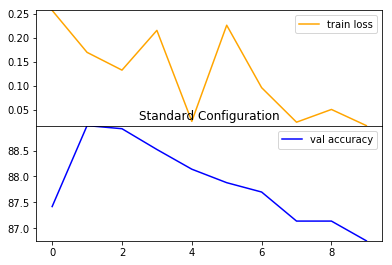

(88.98, 1)

In [479]:
train_and_validate(plot_label = 'Standard Configuration',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 200,id2token = id2token,learning_rate = 0.005,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

learning rate == 0.01

0
1
2
3
4
5
6
7
8
9


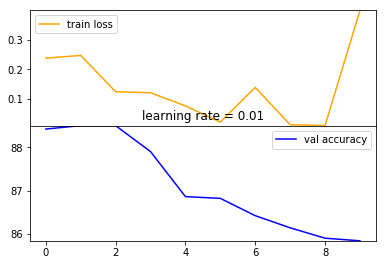

(88.5, 1)

In [514]:
train_and_validate(plot_label = 'learning rate = 0.01',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 200,id2token = id2token,learning_rate = 0.01,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

Learning rate == 0.001

0
1
2
3
4
5
6
7
8
9


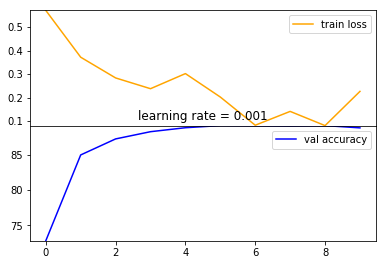

(89.1, 5)

In [515]:
train_and_validate(plot_label = 'learning rate = 0.001',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 200,id2token = id2token,learning_rate = 0.001,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

linear decay

0
1
2
3
4
5
6
7
8
9


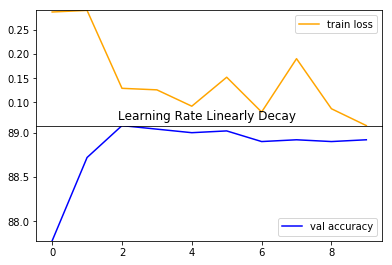

(89.08, 2)

In [516]:
train_and_validate(plot_label = 'Learning Rate Linearly Decay ',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 200,id2token = id2token,learning_rate = 0.005,lr_decay = True, 
                   criterion = torch.nn.CrossEntropyLoss() )

SGD optimizer

0
1
2
3
4
5
6
7
8
9


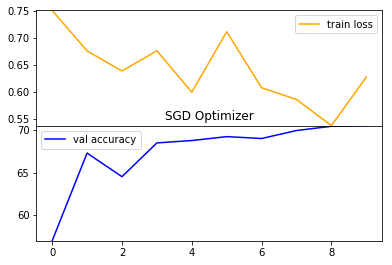

(70.54, 9)

In [523]:

train_and_validate(plot_label = 'SGD Optimizer',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = False,
                   emb_dim = 200,id2token = id2token,learning_rate = 0.005,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

embedding == 100

0
1
2
3
4
5
6
7
8
9


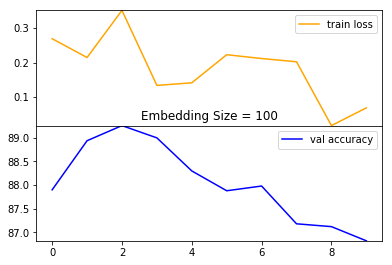

(89.26, 2)

In [519]:
train_and_validate(plot_label = 'Embedding Size = 100',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 100,id2token = id2token,learning_rate = 0.005,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

embedding == 300

0
1
2
3
4
5
6
7
8
9


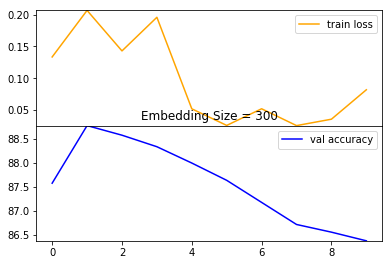

(88.78, 1)

In [520]:
train_and_validate(plot_label = 'Embedding Size = 300',
                   train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                   emb_dim = 300,id2token = id2token,learning_rate = 0.005,lr_decay = False, 
                   criterion = torch.nn.CrossEntropyLoss() )

### Change preprocessing shemes

In [601]:

def ablation_study_on_preprocessing(plot_label,
                                    return_model = False,
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True):
                                    
    token_train1, all_train1 = tokenize_dataset(X_train, 
                                                max_n_gram, 
                                                remove_punc = remove_punc, 
                                                remove_stopwords = remove_stopwords, 
                                                remove_html = remove_html)
    token_val1, all_val1 = tokenize_dataset(X_val,
                                           max_n_gram, 
                                           remove_punc = remove_punc, 
                                           remove_stopwords = remove_stopwords, 
                                           remove_html = remove_html)

    

    token2id, id2token = build_vocab(all_train1,vocab_size)
    token2id_val, id2token_val = build_vocab(all_val1,vocab_size)
    

    train_data_indices = token2index_dataset(token_train1)
    val_data_indices = token2index_dataset(token_val1)
    


    # create pytorch dataloader
    train_loader = IMDBDataset(train_data_indices, y_train)
    val_loader = IMDBDataset(val_data_indices, y_val)
    

    BATCH_SIZE = 32
    train_dataset = IMDBDataset(train_data_indices, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=IMDB_collate_func,
                                               shuffle=True)
    val_dataset = IMDBDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=IMDB_collate_func,
                                               shuffle=True)


    max_acc,index = train_and_validate(plot_label = plot_label,
                                       n_epoch = n_epoch,
                                       train_loader = train_loader,val_loader = val_loader,optimizer_Adam = True,
                                       emb_dim = 100,id2token = id2token,learning_rate = 0.005,lr_decay = True, 
                                       criterion = torch.nn.CrossEntropyLoss() )
    if return_model == True:
        return max_acc,index,model
    else:
        return max_acc,index

1-gram

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


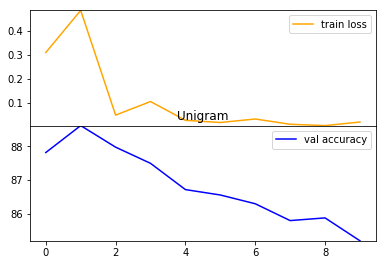

(88.62, 1)

In [503]:
ablation_study_on_preprocessing(plot_label = 'Unigram',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 1,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

2-gram

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


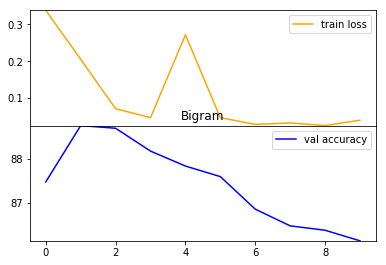

(88.76, 1)

In [504]:
ablation_study_on_preprocessing(plot_label = 'Bigram',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 2,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

3-gram

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


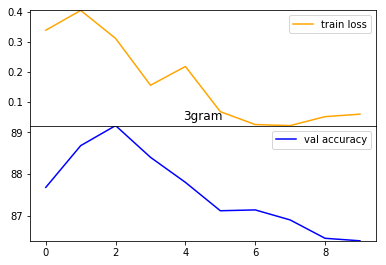

(89.16, 2)

In [505]:
ablation_study_on_preprocessing(plot_label = '3gram',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 3,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

don't remove anything

A Jupyter Widget

A Jupyter Widget

0
1
2
3
4
5
6
7
8
9


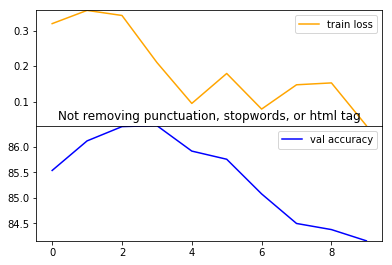

(86.42, 3)

In [502]:
ablation_study_on_preprocessing(plot_label = 'Not removing punctuation, stopwords, or html tag',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 10000,
                                    remove_punc = False,
                                    remove_stopwords = False,
                                    remove_html = False)

only remove punc

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


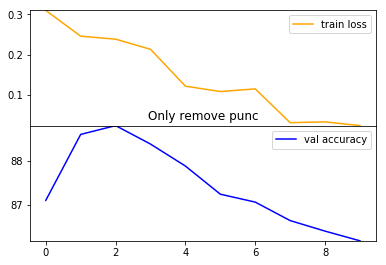

(88.8, 2)

In [508]:
ablation_study_on_preprocessing(plot_label = 'Only remove punc',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = False,
                                    remove_html = False)

remove punc and stop words

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


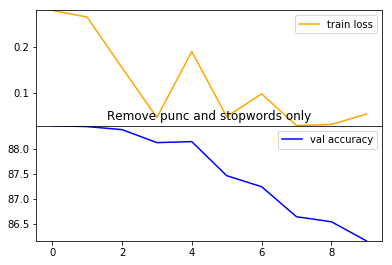

(88.46, 0)

In [509]:
ablation_study_on_preprocessing(plot_label = 'Remove punc and stopwords only',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 10000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = False)

max_vocab_size == 20k

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


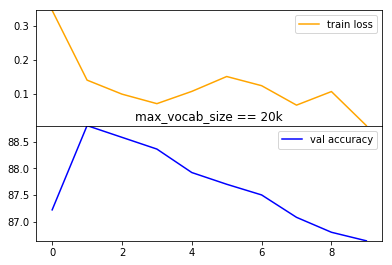

(88.8, 1)

In [510]:
ablation_study_on_preprocessing(plot_label = 'max_vocab_size == 20k',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 20000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

max_vocab_size == 50k

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


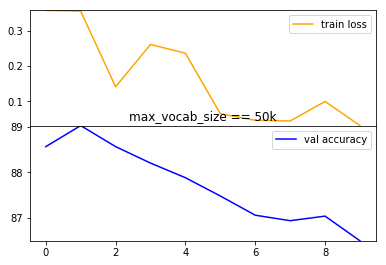

(89.02, 1)

In [511]:
ablation_study_on_preprocessing(plot_label = 'max_vocab_size == 50k',
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 4,
                                    vocab_size = 50000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

Best config: should stop after four epochs (after epoch = 3)

A Jupyter Widget

A Jupyter Widget


0
1
2
3
4
5
6
7
8
9


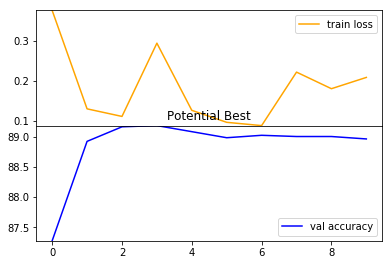

In [602]:
val_acc, epoch, model = ablation_study_on_preprocessing(plot_label = 'Potential Best',
                                    return_model = True,
                                    n_epoch = 10,
                                    X_train = X_train,X_val = X_val, 
                                    max_n_gram = 3,
                                    vocab_size = 50000,
                                    remove_punc = True,
                                    remove_stopwords = True,
                                    remove_html = True)

## Test Accuracy and find correct/incorrect predictions

In [603]:
token_test, all_test = tokenize_dataset(reviews_test, 3)
token2id_test, id2token_test = build_vocab(all_test)
test_data_indices = token2index_dataset(token_test)
print ("Test dataset size is {}".format(len(test_data_indices)))
test_dataset = IMDBDataset(test_data_indices, labels_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)



test_model(test_loader, model)

A Jupyter Widget


Test dataset size is 25000


87.568

In [598]:

# Function for testing the model
def test_model_val(loader, model):
    
    correct = 0
    total = 0
    model.eval()
    counter = 0
    
    correct_pred = dict()
    incorrect_pred = dict()
    
    correct_count = 0
    incorrect_count = 0
    
    correct_idx = []
    incorrect_idx = []
    label_for_correct = []
    label_for_incorrect = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        #print('softmax')
        predicted = outputs.max(1, keepdim=True)[1]
        
        comp = predicted.eq(labels.view_as(predicted))
        
        comp = comp.numpy()
        
        for i in range(len(comp)):
            if correct_count >= 3 and incorrect_count >= 3:
                break
            if correct_count < 3:
                if comp[i] == [1]:
                    correct_idx.append(i)
                    label_for_correct.append(label_batch[i])
                    correct_count += 1
            if incorrect_count < 3:
                if comp[i] == [0]:
                    incorrect_idx.append(i)
                    label_for_incorrect.append(label_batch[i])
                    incorrect_count += 0
            #print (i,comp[i]==[1], 'predicted', predicted[i])
            
        
        print ('Correct: ')
        count = 0
        for c in correct_idx:
            tokens = []
            for w in data_batch[c]:
                tokens.append(id2token[w])
                sentence = ' '.join(tokens)
                correct_pred[c] = sentence
            print (correct_pred[c])
            print ('label:',label_for_correct[count])
            count += 1
                   
        count = 0
        print ('Incorrect: ')
        for c in incorrect_idx:
            tokens = []
            for w in data_batch[c]:
                tokens.append(id2token[w])
                sentence = ' '.join(tokens)
                incorrect_pred[c] = sentence
            print (incorrect_pred[c])
            print ('label:', label_for_incorrect[count])
            count += 1
        break
               
test_model_val(val_loader, model)   




Correct: 
worst movies 've seen 'm sure satire movies uses stupid <unk> cliché think <unk>  don johnson pretty good actually sucked 10 years ago saw hurts wo n't stop lingering brain  the line movie sums stupid wo n't ruin want <unk> fate viewing movie <unk> <unk> moment end better like point laugh maybe worth additionally 're forced date n't like suggest watching movie 'll probably leave 's fair price pay guess <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u